The goal of this notebook is to construct the gene signature scoring add-on to correct for signature gene variance. The idea is that if we correct for signature gene variance the scores might become more comparable for different signatures. Especially, if the signatures contain genes, which show clear difference in the signature gene variances.

In [1]:
import sys

import numpy as np
import pandas as pd
import scanpy as sc
from matplotlib import pyplot as plt
from scanpy.preprocessing._utils import _get_mean_var
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from skmisc.loess import loess

sys.path.append('../..')

from data.load_esophageal_data import load_esophageal_data
from src.data.preprocess_data import preprocess
from src.utils.utils import get_gene_list_real_data, check_signature_genes

sc.settings.verbosity = 3

## Load and preprocess the data

In [2]:
dict_samples = load_esophageal_data(small=True)

Load data and separate data per sample


In [3]:
dict_samples

{'P23T': AnnData object with n_obs × n_vars = 3478 × 14201
     obs: 'sample_id', 'celltype', 'batch', 'healthy_annotation', 'reference', 'barcode', 'n_counts', 'log_counts', 'n_genes', 'pct_zero_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'reference_type', 'healthy_cnv', 'healthy', 'S_score', 'G2M_score', 'phase', 'apoptosis_score', 'oxphos', 'AP', 'Cycling', 'Epi1', 'Epi2', 'Mes', 'Mucosal', 'Oxd', 'Stress', 'subclonal'
     var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'chromosome', 'start', 'end', 'cutoff'
     uns: 'cnv', 'reference_cat', 'reference_info'
     obsm: 'X_cnv',
 'P61T': AnnData object with n_obs × n_vars = 2763 × 14201
     obs: 'sample_id', 'celltype', 'batch', 'healthy_annotation', 'reference', 'barcode', 'n_counts', 'log_counts', 'n_genes', 'pct_zero_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'reference_type', 'healthy_cnv', 'healthy', 'S_score', 'G

In [4]:
for key, val in dict_samples.items():
    preprocess(val,
               min_genes=500,
               min_cells=5,
               target_sum=1e4,
               verbose=0)

filtered out 27 genes that are detected in less than 5 cells
normalizing counts per cell
    finished (0:00:00)
filtered out 116 genes that are detected in less than 5 cells
normalizing counts per cell
    finished (0:00:00)
filtered out 100 genes that are detected in less than 5 cells
normalizing counts per cell
    finished (0:00:00)


In [5]:
adata = sc.concat(dict_samples.values(), join='inner', merge='same')

In [6]:
# adata = sc.read_h5ad('../data/synthetic_data/5vs95_w_batch_effect/dataset.hdf5')

In [343]:
# # adata

In [344]:
# dict_samples = {}
# for group in adata.obs.groupby('Batch'):
#     tmp_data = adata[group[1].index,:].copy()
#     preprocess(tmp_data,
#                min_genes=200,
#                min_cells=3,
#                target_sum=1e4,
#                verbose=0)
#
#     dict_samples[group[0]] =tmp_data
#

In [345]:
# adata = sc.concat(dict_samples.values(), join='inner', merge='same')

### Construct smoothed variance on log-normalized data

In [7]:
var_names = adata.var_names.tolist()

In [8]:
df = pd.DataFrame()
df['mean'], df['var'] = _get_mean_var(adata.X)
df = df.set_index(adata.var_names)
df = df.sort_values(by='mean')

In [9]:
#reg = LinearRegression().fit(np.log10(df['mean'].to_numpy().reshape(-1, 1)), np.log10(df['var']))
reg = LinearRegression().fit(df['mean'].to_numpy().reshape(-1, 1),df['var'])

In [10]:
estimated_var = reg.predict(df['mean'].to_numpy().reshape(-1, 1))
print(r2_score(np.log10(df['var']),estimated_var))
estimated_var = 10 ** estimated_var
df['estimat_std_reg'] = np.sqrt(estimated_var)
df['estimat_var_reg'] = estimated_var

-4.711815972652098


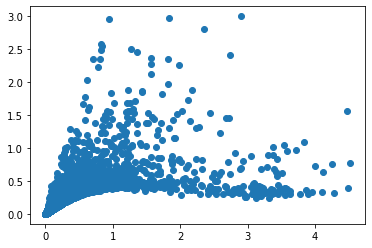

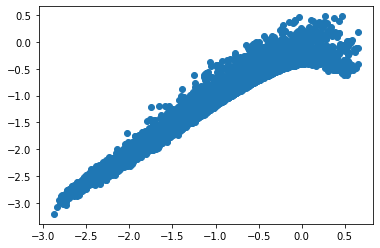

In [11]:
plt.scatter(df['mean'], df['var'])
plt.show()
plt.scatter(np.log10(df['mean']), np.log10(df['var']))
plt.show()

In [12]:
not_const = df['var'] > 0
estimat_var = np.zeros(adata.X.shape[1], dtype=np.float64)

y = np.log10(df['var'][not_const])
x = np.log10(df['mean'][not_const])
model = loess(x, y, span=0.3, degree=2)
model.fit()
estimat_var[not_const] = model.outputs.fitted_values
reg_std = np.sqrt(10**estimat_var)
df['estimat_std_loess'] = reg_std
df['estimat_var_loess'] = 10**estimat_var

In [13]:
r2_score(y,estimat_var[not_const])

0.9721523509565587

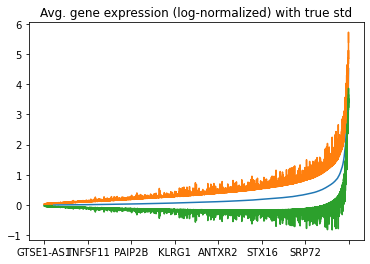

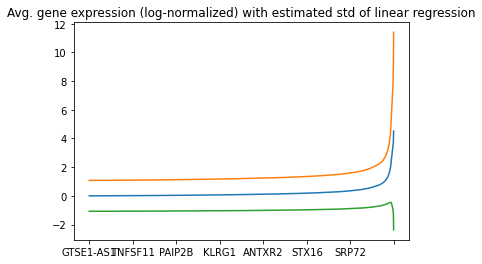

Text(0.5, 1.0, 'Avg. gene expression (log-normalized) with estimated std of loess')

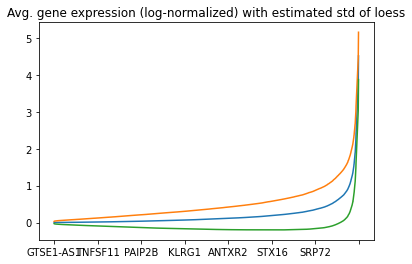

In [14]:
(df['mean']).plot()
(df['mean'] + np.sqrt(df['var'])).plot()
(df['mean'] - np.sqrt(df['var'])).plot()
plt.title('Avg. gene expression (log-normalized) with true std')
plt.show()
(df['mean']).plot()
(df['mean'] + df['estimat_std_reg']).plot()
(df['mean'] - df['estimat_std_reg']).plot()
plt.title('Avg. gene expression (log-normalized) with estimated std of linear regression')
plt.show()
(df['mean']).plot()
(df['mean'] + df['estimat_std_loess']).plot()
(df['mean'] - df['estimat_std_loess']).plot()
plt.title('Avg. gene expression (log-normalized) with estimated std of loess')

### Construct smoothed variance on normalized data

In [328]:
df = pd.DataFrame()
df['mean'], df['var'] = _get_mean_var(np.expm1(adata.X))
df = df.set_index(adata.var_names)
df = df.sort_values(by='mean')

In [329]:
reg = LinearRegression().fit(np.log10(df['mean'].to_numpy().reshape(-1, 1)), np.log10(df['var']))

In [330]:
estimated_var = reg.predict(np.log10(df['mean'].to_numpy().reshape(-1, 1)))
r2_score(np.log10(df['var']), estimated_var)
estimated_var = 10 ** estimated_var
df['estimat_std_reg'] = np.sqrt(estimated_var)
df['estimat_var_reg'] = estimated_var

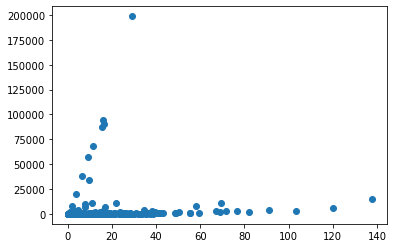

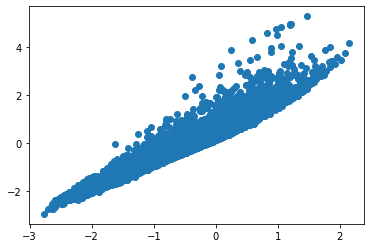

In [331]:
plt.scatter(df['mean'], df['var'])
plt.show()
plt.scatter(np.log10(df['mean']), np.log10(df['var']))
plt.show()

In [332]:
not_const = df['var'] > 0
estimat_var = np.zeros(adata.X.shape[1], dtype=np.float64)

y = np.log10(df['var'][not_const])
x = np.log10(df['mean'][not_const])
model = loess(x, y)
model.fit()
estimat_var[not_const] = model.outputs.fitted_values
reg_std = np.sqrt(10**estimat_var)
df['estimat_std_loess'] = reg_std
df['estimat_var_loess'] = 10**estimat_var

In [333]:
r2_score(y,estimat_var[not_const])

0.9278276412327555

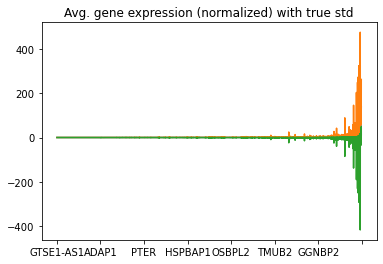

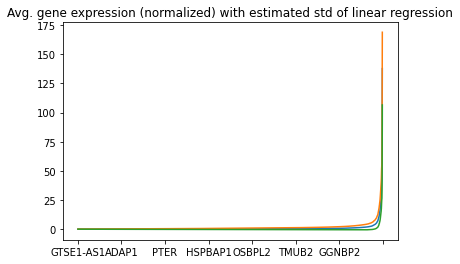

Text(0.5, 1.0, 'Avg. gene expression (normalized) with estimated std of loess')

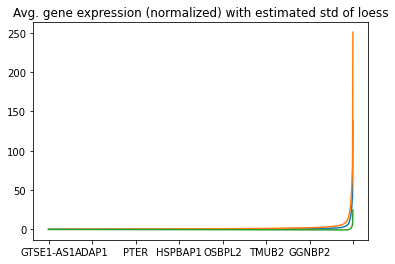

In [334]:
(df['mean']).plot()
(df['mean'] + np.sqrt(df['var'])).plot()
(df['mean'] - np.sqrt(df['var'])).plot()
plt.title('Avg. gene expression (normalized) with true std')
plt.show()
(df['mean']).plot()
(df['mean'] + df['estimat_std_reg']).plot()
(df['mean'] - df['estimat_std_reg']).plot()
plt.title('Avg. gene expression (normalized) with estimated std of linear regression')
plt.show()
(df['mean']).plot()
(df['mean'] + df['estimat_std_loess']).plot()
(df['mean'] - df['estimat_std_loess']).plot()
plt.title('Avg. gene expression (normalized) with estimated std of loess')

In [335]:
df = df.apply(lambda x: np.log1p(x), axis=1)

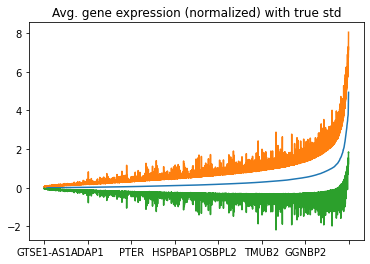

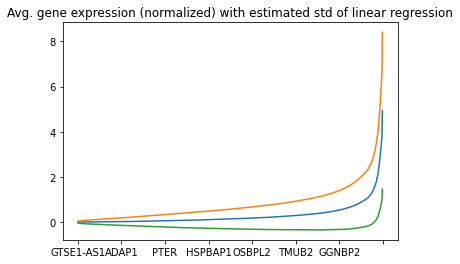

Text(0.5, 1.0, 'Avg. gene expression (normalized) with estimated std of loess')

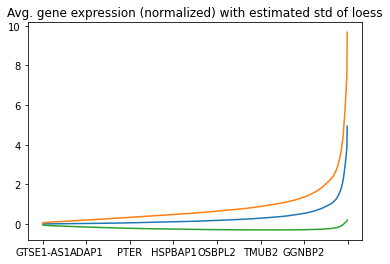

In [336]:
(df['mean']).plot()
(df['mean'] + np.sqrt(df['var'])).plot()
(df['mean'] - np.sqrt(df['var'])).plot()
plt.title('Avg. gene expression (normalized) with true std')
plt.show()
(df['mean']).plot()
(df['mean'] + df['estimat_std_reg']).plot()
(df['mean'] - df['estimat_std_reg']).plot()
plt.title('Avg. gene expression (normalized) with estimated std of linear regression')
plt.show()
(df['mean']).plot()
(df['mean'] + df['estimat_std_loess']).plot()
(df['mean'] - df['estimat_std_loess']).plot()
plt.title('Avg. gene expression (normalized) with estimated std of loess')

### Get Signature separating for healthy and unhealthy cells

In [15]:
gene_list = get_gene_list_real_data(
    adata,
    dge_pval_cutoff=0.01,
    dge_log2fc_min=0.01,
    nr_de_genes=50,
    mode='random',
)

ranking genes


/anaconda3/envs/mt/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'sample_id' as categorical
/anaconda3/envs/mt/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'subclonal' as categorical


    finished: added to `.uns['wilcoxon']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:02:46)


## Construction scoring with signature gene variance adustment

In [16]:
var_names = adata.var_names.tolist()
gene_list = check_signature_genes(var_names, gene_list)

In [17]:
df = pd.DataFrame()

In [18]:
df['mean'], df['var'] = _get_mean_var(adata.X)
df = df.set_index(adata.var_names)
df = df.sort_values(by='mean')

In [19]:
not_const = df['var'] > 0
estimat_var = np.zeros(adata.X.shape[1], dtype=np.float64)

y = np.log10(df['var'][not_const])
x = np.log10(df['mean'][not_const])
model = loess(x, y, span= 0.3,degree=2)
model.fit()
estimat_var[not_const] = model.outputs.fitted_values
reg_std = np.sqrt(10**estimat_var)
df['estimate_std'] = reg_std
df['estimate_var'] = 10**estimat_var

In [53]:
x.shape

(13983,)

In [20]:
hasattr(df, 'attrs')

True

In [21]:
df.attrs['loess_r2_score'] = r2_score(y, model.outputs.fitted_values)

In [22]:
df.attrs

{'loess_r2_score': 0.9721523509565587}

Text(0.5, 1.0, 'Relationship mean vs. var/ estimated var, R2-score:0.972')

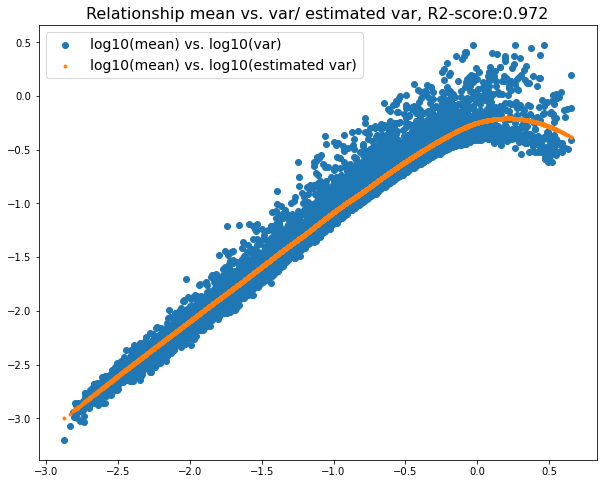

In [23]:
fig = plt.figure(figsize=(10,8))
plt.scatter(x,y, label='log10(mean) vs. log10(var)')
plt.scatter(x,estimat_var[not_const],marker='.',label='log10(mean) vs. log10(estimated var)')
plt.legend(fontsize=14)
plt.title(f'Relationship mean vs. var/ estimated var, R2-score:{str(np.round(r2_score(y, model.outputs.fitted_values), decimals=3))}', fontsize=16)

In [60]:
fig.savefig('../plots/mean_var_realationship_2.png', format='png')

In [24]:
gene_means = df['mean']
ref_gene_means = gene_means[gene_means.index.isin(gene_list) == False]

In [25]:
rolled = ref_gene_means.rolling(100, closed='right').mean()

In [26]:
control_genes = []
for sig_gene in gene_list:
    curr_sig_avg = gene_means.loc[sig_gene]
    min_val_idx = np.argmin(((rolled - curr_sig_avg).abs()))
    sig_gene_ctrl_genes = rolled.iloc[(min_val_idx - 100 + 1):min_val_idx + 1]
    control_genes.append(list(sig_gene_ctrl_genes.index))

In [27]:
df.loc['METTL20',:].estimate_std

0.10091962228442057

Here we want to check whether the std of the mean is the same as the mean of the std

In [64]:
last_sig_gene_ctrl_set = control_genes[25]

In [65]:
last_sig_gene_ctrl_set

['TIGD6',
 'ACRC',
 'KCNK12',
 'PEX11G',
 'NCS1',
 'CTD-3131K8.2',
 'CEP72',
 'CNIH3',
 'DEPDC1',
 'CCL8',
 'TRGV7',
 'ZNF367',
 'ZNF283',
 'KLHL35',
 'SYNC',
 'NKX3-1',
 'ATP10A',
 'KIF5C',
 'REEP2',
 'ZNF626',
 'HIST1H2AB',
 'ZC4H2',
 'FAM110C',
 'PPM1N',
 'SLC16A14',
 'ZNF347',
 'LRRC49',
 'ZNF596',
 'TRIM61',
 'SLC22A4',
 'AGAP1',
 'ZNF582',
 'DNAH1',
 'ZNF540',
 'FPGT',
 'FOXRED2',
 'PTK6',
 'AC011043.1',
 'FCRLB',
 'CCR10',
 'USP51',
 'UFSP1',
 'SLC4A8',
 'RP11-473M20.9',
 'RP11-426C22.5',
 'ZBED6',
 'ZNF354C',
 'NPTX2',
 'RP11-77K12.1',
 'FAXDC2',
 'TRO',
 'CES4A',
 'TMEM231',
 'P2RX7',
 'LYPD5',
 'RP11-817O13.8',
 'ZNF222',
 'RAD54B',
 'HGF',
 'RP11-392P7.6',
 'TFPI2',
 'INTU',
 'ACOT11',
 'RP11-24F11.2',
 'SLC16A4',
 'INTS6-AS1',
 'ELOVL4',
 'PPIL6',
 'STBD1',
 'APOM',
 'THRB',
 'RFESD',
 'FANCE',
 'ZNF528',
 'MMACHC',
 'CTD-2341M24.1',
 'SCARF2',
 'FAM169A',
 'TIGD2',
 'AC024592.12',
 'TNFRSF8',
 'NUDT6',
 'GALNT4',
 'NEK2',
 'CTTNBP2',
 'DLG4',
 'LRRC29',
 'DYX1C1',
 'ZNF81'

In [66]:
df.loc[last_sig_gene_ctrl_set,:]

,mean,var,estimate_std,estimate_var
TIGD6,0.015813,0.011589,0.112876,0.012741
ACRC,0.015816,0.015561,0.112886,0.012743
KCNK12,0.015817,0.014966,0.112891,0.012744
PEX11G,0.015821,0.010250,0.112904,0.012747
NCS1,0.015835,0.011739,0.112954,0.012759
...,...,...,...,...
BOLA3-AS1,0.016696,0.013340,0.115992,0.013454
POLR3G,0.016699,0.010039,0.116005,0.013457
EPDR1,0.016708,0.014903,0.116033,0.013464
RP11-338I21.1,0.016709,0.019587,0.116040,0.013465


In [67]:
new_point = np.ndarray(shape=(1,) )

In [68]:
new_point[0] = np.log10(df.loc[last_sig_gene_ctrl_set,:]['mean'].mean())

In [69]:
new_point

array([-1.78924252])

In [70]:
prediction_new_point = model.predict(newdata=new_point)

In [71]:
estim_var = 10 ** prediction_new_point.values

In [72]:
estim_std = np.sqrt(estim_var)

In [73]:
estim_std[0]

0.11441707827334702

In [74]:
(df.loc[last_sig_gene_ctrl_set,:]['estimate_std']).mean()

0.11441243777763997

In [ ]:
from src.utils.utils import nanmean

scores_per_sig_gene = []
for sig_gene, ctrl_genes in zip(gene_list,control_genes):
    O = nanmean(adata[:, sig_gene].X, axis=1, dtype="float64")
    E = nanmean(adata[:, ctrl_genes].X, axis=1, dtype="float64")
    scores_per_sig_gene.append((O-E)/df.loc[sig_gene,'estimate_std'])

In [ ]:
df['estimate_std']

In [ ]:
isinstance(df,pd.core.frame.DataFrame)

In [ ]:
all(x in df['estimate_std'].index for x in gene_list)

In [ ]:
scores_per_sig_gene = np.vstack(scores_per_sig_gene)
scores_per_sig_gene = scores_per_sig_gene.T

In [ ]:
scores_per_sig_gene

In [ ]:
scores_per_sig_gene.shape

In [ ]:
scores_mean = np.mean(scores_per_sig_gene, axis=1)
scores_median = np.median(scores_per_sig_gene, axis=1)

In [ ]:
adata.obs.healthy

In [ ]:
plt.hist(scores_mean[adata.obs.healthy=='healthy'], bins = 20, alpha = 0.5, density = True, label='healthy')
plt.hist(scores_mean[adata.obs.healthy=='unhealthy'], bins = 20, alpha = 0.5, density = True, label='unhealthy')
plt.legend()

In [ ]:
plt.hist(scores_median[adata.obs.healthy=='healthy'], bins = 20, alpha = 0.5, density = True, label='healthy')
plt.hist(scores_median[adata.obs.healthy=='unhealthy'], bins = 20, alpha = 0.5, density = True, label='unhealthy')
plt.legend()

In [ ]:
from src.scoring_methods.gene_signature_scoring import score_signature

score_signature(
    method = 'adjusted_neighborhood_scoring',
    adata=adata,
    gene_list = gene_list,
    ctrl_size = 100,
    score_name = 'wo-var-adjustment'
)


In [ ]:
plt.hist(adata.obs[adata.obs.healthy=='healthy']['wo-var-adjustment'], bins = 20, alpha = 0.5, density = True, label='healthy')
plt.hist(adata.obs[adata.obs.healthy=='unhealthy']['wo-var-adjustment'], bins = 20, alpha = 0.5, density = True, label='unhealthy')
plt.legend()

In [ ]:
from sklearn.metrics import roc_auc_score, f1_score

AUCS = [roc_auc_score(adata.obs.healthy, scores_mean),
        roc_auc_score(adata.obs.healthy, scores_median),
        roc_auc_score(adata.obs.healthy, adata.obs['wo-var-adjustment']),]

scores_mean_labels = adata.obs.healthy.copy()
scores_mean_labels[scores_mean>0] = 'unhealthy'
scores_mean_labels[scores_mean<=0] = 'healthy'
scores_median_labels = adata.obs.healthy.copy()
scores_median_labels[scores_median>0] = 'unhealthy'
scores_median_labels[scores_median<=0] = 'healthy'
scores_wo_var_mean_labels = adata.obs.healthy.copy()
scores_wo_var_mean_labels[adata.obs['wo-var-adjustment']>0] = 'unhealthy'
scores_wo_var_mean_labels[adata.obs['wo-var-adjustment']<=0] = 'healthy'

F1S = [f1_score(adata.obs.healthy, scores_mean_labels, pos_label='unhealthy'),
       f1_score(adata.obs.healthy, scores_median_labels, pos_label='unhealthy'),
       f1_score(adata.obs.healthy, scores_wo_var_mean_labels, pos_label='unhealthy'),]


print(F1S,AUCS)

In [ ]:
adata.obs['wo-var-adjustment']

In [ ]:
curr_gt = scores_mean_labels.copy().astype(str)

In [ ]:
label_of_interest = 'unhealthy'

In [ ]:
curr_gt.loc[curr_gt != label_of_interest] = 'not ' + label_of_interest

In [ ]:
curr_gt

### Test Adjusted Neighborhood scoring for new way to compute mean and variance

In [ ]:
score_signature(
    method = 'adjusted_neighborhood_scoring',
    adata=adata,
    gene_list = gene_list,
    ctrl_size = 100,
    score_name = 'ANS'
)

In [12]:
score_signature(
    method = 'adjusted_neighborhood_scoring',
    adata=adata,
    gene_list = gene_list,
    ctrl_size = 100,
    score_name = 'ANS_w_std_adjustment_std',
    adjust_for_gene_std = True,
    adjust_for_all_genes = False,
    adjust_for_gene_std_var_1p = False,
    store_path_mean_var_data = r'/Users/laure.ciernik/Library/Mobile Documents/com~apple~CloudDocs/Masterarbeit/mt_gene_signature_scoring/plots'
)

score_signature(
    method = 'adjusted_neighborhood_scoring',
    adata=adata,
    gene_list = gene_list,
    ctrl_size = 100,
    score_name = 'ANS_w_std_adjustment_std_var_1p',
    adjust_for_gene_std = True,
    adjust_for_all_genes = False,
    adjust_for_gene_std_var_1p = True,
    store_path_mean_var_data = r'/Users/laure.ciernik/Library/Mobile Documents/com~apple~CloudDocs/Masterarbeit/mt_gene_signature_scoring/plots'
)

computing score 'ANS_w_std_adjustment_std'
    finished: added
    'ANS_w_std_adjustment_std', score of gene set (adata.obs).
    50 total control genes are used. (0:00:09)
computing score 'ANS_w_std_adjustment_std_var_1p'
    finished: added
    'ANS_w_std_adjustment_std_var_1p', score of gene set (adata.obs).
    50 total control genes are used. (0:00:08)


In [25]:
score_signature(
    method = 'adjusted_neighborhood_scoring',
    adata=adata,
    gene_list = gene_list,
    ctrl_size = 100,
    score_name = 'ANS_w_std_adjustment_all',
    adjust_for_gene_std = True,
    adjust_for_all_genes = True,
    adjust_for_gene_std_var_1p = False,
    store_path_mean_var_data = r'/Users/laure.ciernik/Library/Mobile Documents/com~apple~CloudDocs/Masterarbeit/mt_gene_signature_scoring/plots'
)
score_signature(
    method = 'adjusted_neighborhood_scoring',
    adata=adata,
    gene_list = gene_list,
    ctrl_size = 100,
    score_name = 'ANS_w_std_adjustment_all_var_1p',
    adjust_for_gene_std = True,
    adjust_for_all_genes = True,
    adjust_for_gene_std_var_1p = True,
    store_path_mean_var_data = r'/Users/laure.ciernik/Library/Mobile Documents/com~apple~CloudDocs/Masterarbeit/mt_gene_signature_scoring/plots'
)

computing score 'ANS_w_std_adjustment_all'
    finished: added
    'ANS_w_std_adjustment_all', score of gene set (adata.obs).
    50 total control genes are used. (0:00:04)
computing score 'ANS_w_std_adjustment_all_var_1p'
    finished: added
    'ANS_w_std_adjustment_all_var_1p', score of gene set (adata.obs).
    50 total control genes are used. (0:00:03)


### Test scoring for tirosch and other scoring functions

In [12]:
score_signature(
    method = 'tirosh_scoring',
    adata=adata,
    gene_list = gene_list,
    ctrl_size = 100,
    n_bins = 25,
    score_name = 'TS_old_version',
    old_version = True
)

score_signature(
    method = 'tirosh_scoring',
    adata=adata,
    gene_list = gene_list,
    ctrl_size = 100,
    n_bins = 25,
    score_name = 'TS_new_version',
    old_version = False
)

computing score 'TS_old_version'
No store_path indicated, thus no data stored.
    finished: added
    'TS_old_version', score of gene set (adata.obs).
    5000 total control genes are used. (0:00:06)
computing score 'TS_new_version'
No store_path indicated, thus no data stored.
    finished: added
    'TS_new_version', score of gene set (adata.obs).
    5000 total control genes are used. (0:00:00)


In [16]:
adata.obs['TS_new_version'].compare(adata.obs['TS_old_version'])

,self,other
index,,
P23T-I-AAACGGGAGGCCATAG-0,0.016066,0.016066
P23T-I-AAAGATGAGCACACAG-0,0.101435,0.101435
P23T-I-AAAGCAACAGCGTTCG-0,0.026990,0.026990
P23T-I-AAAGCAATCAGTGCAT-0,0.024823,0.024823
P23T-I-AAAGTAGTCGTCTGAA-0,0.011998,0.011998
...,...,...
P62T-I-TTTGCGCGTTTGACAC-7,-0.039232,-0.039232
P62T-I-TTTGCGCTCCTTTACA-7,-0.052816,-0.052816
P62T-I-TTTGGTTAGTAGATGT-7,0.079957,0.079957


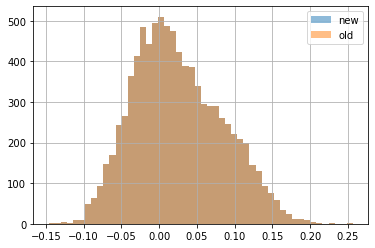

In [14]:
adata.obs['TS_new_version'].hist(bins=50, alpha = 0.5, label='new')
adata.obs['TS_old_version'].hist(bins=50, alpha = 0.5, label='old')
plt.legend()

In [17]:
from src.utils.metrics import get_AUC_and_F1_performance

get_AUC_and_F1_performance(
    adata,
    scoring_names = ['TS_new_version','TS_old_version']
)

,Scoring method,Test method,Statistic,pvalue,scoring_for
0,ts_old_version,auc,0.917104,NaN,unhealthy
1,ts_old_version,auc-dist,0.938141,NaN,unhealthy
2,ts_old_version,f1,0.519251,NaN,unhealthy
3,ts_new_version,auc,0.917104,NaN,unhealthy
4,ts_new_version,auc-dist,0.938141,NaN,unhealthy
5,ts_new_version,f1,0.519251,NaN,unhealthy
